# roAp Classification using A.I.
### Not using regressions, like in CS 455 project; using vectorization to classify groupings in the cluster. 
### Updates:
* Initial: (09/15/2023)
    - Need to look into using KNN and so called vectorization. (X)
    - Started to characterize via matrices and find thresholds from known errors
* Update (10/25/2023)
    - Found the errors
    - Need to calculate the ellipse

In [22]:
# Packages for AI development
from sklearn import neighbors, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
# Packages for porting databases into python
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import TapPlus
# General packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from sympy import *
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

## WORK ON PORTING DATABASES IN FROM GAIA, STARHORSE, ETC. 
#### ~ Not neccessary at the moment

In [23]:
'''Gaia.ROW_LIMIT = 50  # Ensure the default row limit.
coord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
j = Gaia.cone_search_async(coord, radius=u.Quantity(1.0, u.deg))

r = j.get_results()
r.pprint()'''

"Gaia.ROW_LIMIT = 50  # Ensure the default row limit.\ncoord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')\nj = Gaia.cone_search_async(coord, radius=u.Quantity(1.0, u.deg))\n\nr = j.get_results()\nr.pprint()"

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars
        'all' is the concatenated of the two

In [24]:
r = pd.read_csv('Data/field_roAp_gaiaNstarhorse.csv', index_col=False)
c = pd.read_csv('Data/15MON_A0_FOV.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns

roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
dbr = np.append(np.array(roAp), np.array(roAp), axis=1)
dbc = np.append(np.array(clust), np.array(clust), axis=1)
# Concatenating datasets to find roAp condidates in NGC 2264
all = pd.concat([roAp, clust],axis=0)
all['designation'] = all['designation'].str.replace(r'\D', '')
db = np.append(np.array(all),np.array(all),axis=1)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values
y = (all['GMAG0']).values
x = (all['BP-RP0']).values
des = (all['designation']).values
# Error values used for threshold value
exr = (roAp['AG50']).values
eyr = (roAp['AB50-AR50']).values
exc = (clust['AG50']).values
eb = (clust['ABP50']).values
er = (clust['ARP50']).values
eyc = eb-er

print('ID: ', [des])
print('Features:', len(yr))
print('Target:', len(yc))
print('---------')
print('Total Dataset for field roAps:', dbr.data.shape)
print('Total Dataset for NGC 2264:', dbc.data.shape)
print('Concatenated Dataset:',all.shape)
all.describe()

ID:  [array(['Gaia DR3 6490573544291074304', 'Gaia DR3 2382427228199293824',
       'Gaia DR3 1932476489951202432', ...,
       'Gaia DR3 3326946298150447232', 'Gaia DR3 3326946439886003072',
       'Gaia DR3 3326946852202845312'], dtype=object)]
Features: 87
Target: 965
---------
Total Dataset for field roAps: (87, 240)
Total Dataset for NGC 2264: (965, 172)
Concatenated Dataset: (1052, 139)


,num,id,ra,RA_ICRS,dec,DE_ICRS,GMAG0,BP-RP0,ecl_lon,ecl_lat,...,azero_gspphot,bp_g,distance_gspphot,ebpminrp_gspphot,g_rp,grvs_mag,grvs_mag_error,logg_gspphot,mh_gspphot,phot_rp_mean_flux_error
count,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,1052.000000,...,846.000000,965.000000,846.000000,846.000000,965.000000,127.000000,127.000000,846.000000,846.000000,965.000000
mean,0.082700,531.314639,108.374667,108.374656,7.670222,7.670215,3.447400,0.760021,109.035112,-13.087278,...,2.211731,0.999969,873.526163,0.912925,0.976711,12.503708,0.073577,4.376956,-1.251781,77.776609
std,0.275559,304.138043,39.597833,39.597769,13.538111,13.538141,2.113787,0.467524,40.736884,12.668675,...,1.632576,0.363524,597.824320,0.670453,0.190073,1.210838,0.063511,0.459858,1.033316,1033.807892
min,0.000000,0.000000,2.127157,2.127157,-81.902104,-81.902104,-2.724406,-0.274474,2.019759,-85.377605,...,0.000300,-0.047375,80.719500,0.000100,0.029116,7.257843,0.005903,1.560400,-4.080400,6.360226
25%,0.000000,268.750000,100.118931,100.118931,9.799350,9.799350,2.155089,0.543340,100.235738,-13.265299,...,0.886650,0.781023,581.634550,0.347425,0.887848,12.066604,0.029815,4.194500,-1.636250,12.372756
50%,0.000000,531.500000,100.242384,100.242384,9.921532,9.921532,3.420237,0.715932,100.362837,-13.137302,...,1.999000,0.977806,684.458100,0.819900,0.995651,12.808246,0.062369,4.455300,-1.098800,15.658791
75%,0.000000,794.250000,100.430122,100.430122,10.019443,10.019443,4.369588,0.922527,100.556503,-13.049740,...,3.126950,1.178103,919.567975,1.303950,1.093529,13.332334,0.105035,4.713975,-0.429025,24.481014
max,1.000000,1057.000000,348.317184,348.305087,58.526905,58.526905,13.284124,3.569711,336.146049,69.335987,...,8.914300,2.576562,5316.184000,3.478100,1.469299,14.090522,0.507102,5.158000,0.635400,31803.912000


#### 1.1 Transposing the x and y datasets

In [25]:
# For roAp dataset
xr_array = np.array([xr])
xrp_array = xr_array.transpose()

yr_array = np.array([yr])
yrp_array = yr_array.transpose()

# For cluster dataset
xc_array = np.array([xc])
yc_array = np.array([yc])


print(xc_array.shape)
# Only transposing one so that we can evenly distribute the values

(1, 965)


#### 1.2 Making roAp array a NxM matrix and cluster array an MxN matric

In [26]:
# Making the roAp arrays a NxM matrix
xrp_array_m = np.tile((xrp_array), (1,len(xc)))
yrp_array_m = np.tile((yrp_array), (1,len(yc)))
# Making the cluter array a MxN matrix
xc_array_n = np.tile((xc_array), (len(xr),1))
yc_array_n = np.tile((yc_array), (len(yr),1))

#### 1.3 Calculating the squares to then find the $R^2$ values

In [27]:
# Squares of the roAp arrays 
sq_xrp_array = (xrp_array_m)**2
sq_yrp_array = (yrp_array_m)**2
# Squares of the cluster array
sq_xc_array = (xc_array_n)**2
sq_yc_array = (yc_array_n)**2
# Calculating R**2 value
sq_r = np.sqrt(sq_xrp_array + sq_yrp_array)
sq_c = np.sqrt(sq_xc_array + sq_yc_array)


print(sq_r)
print('----------------\n', sq_c,'\n--------------\n')
print('Shape of Rx:',sq_r.shape,'\n','Shape of Ry:',sq_c.shape)

[[5.74232177 5.74232177 5.74232177 ... 5.74232177 5.74232177 5.74232177]
 [1.73452338 1.73452338 1.73452338 ... 1.73452338 1.73452338 1.73452338]
 [2.18746794 2.18746794 2.18746794 ... 2.18746794 2.18746794 2.18746794]
 ...
 [1.74279689 1.74279689 1.74279689 ... 1.74279689 1.74279689 1.74279689]
 [2.7255858  2.7255858  2.7255858  ... 2.7255858  2.7255858  2.7255858 ]
 [1.43161351 1.43161351 1.43161351 ... 1.43161351 1.43161351 1.43161351]]
----------------
 [[10.50488068  0.75332313  2.57219877 ...  4.75417103  3.61976119
   0.53737635]
 [10.50488068  0.75332313  2.57219877 ...  4.75417103  3.61976119
   0.53737635]
 [10.50488068  0.75332313  2.57219877 ...  4.75417103  3.61976119
   0.53737635]
 ...
 [10.50488068  0.75332313  2.57219877 ...  4.75417103  3.61976119
   0.53737635]
 [10.50488068  0.75332313  2.57219877 ...  4.75417103  3.61976119
   0.53737635]
 [10.50488068  0.75332313  2.57219877 ...  4.75417103  3.61976119
   0.53737635]] 
--------------

Shape of Rx: (87, 965) 
 Shap

### 2. Making to ellipses for classification
        Essentially finding the angle of the slope of each point

#### 2.1 Calculating a threshold value based off of the error in the roAp datasets.

In [28]:
ex_array = np.array([exr])
ey_array = np.array([eyr])

t = np.sqrt(ex_array**2+ey_array**2).transpose()
thresh = np.tile(t, (1,len(xc)))
print(thresh.shape)

(87, 965)


#### 2.2 Using the R and angle a values to find the deviations and the threshold value to find candidates

    Basically want for an individual point in the array:
        if dist<thresh, then select as a candidate

In [29]:
# Finding the error from BP-RP and saving the G error values
sb_r = []
r = []
dr = (roAp['designation']).values
gme = (roAp['phot_g_mean_mag_error']).values

for n in range(len(xr)):
    sb_r = np.sqrt(((roAp['phot_bp_mean_mag_error']).values[n])**2+((roAp['phot_rp_mean_mag_error']).values[n])**2)
    r.append({'Designation':dr[n],'G_mean_error':gme[n],'BP-RP_mean_error':sb_r})
    #print(r[n])
dfr = pd.DataFrame(r)
print(dfr,'\n-----------------------------------------------------------------')
dfr.describe()

                     Designation  G_mean_error  BP-RP_mean_error
0   Gaia DR3 6490573544291074304      0.002864          0.014236
1   Gaia DR3 2382427228199293824      0.002788          0.004754
2   Gaia DR3 1932476489951202432      0.002798          0.004788
3   Gaia DR3 2401638960512043264      0.002762          0.004736
4   Gaia DR3 2173914571812599680      0.002770          0.004749
..                           ...           ...               ...
82   Gaia DR3 505502605482123648      0.002767          0.004890
83  Gaia DR3 2458519755033679360      0.002899          0.004811
84  Gaia DR3 5034539498772633856      0.002780          0.004978
85  Gaia DR3 2426233764315367040      0.002766          0.004728
86  Gaia DR3 2741721583476129664      0.002768          0.004720

[87 rows x 3 columns] 
-----------------------------------------------------------------


,G_mean_error,BP-RP_mean_error
count,87.000000,87.000000
mean,0.002829,0.005238
std,0.000233,0.001476
min,0.002760,0.004716
25%,0.002768,0.004763
50%,0.002773,0.004809
75%,0.002790,0.005051
max,0.004316,0.014236


#### EDIT ~ Turns out Gaia EDR3 already has mean mag errors... These give a very small percent difference, thus instead of caluclating them using the Flux I will just use these. 

0.936648 5.665417 
 0.014235863584623169 0.002864
<Axes.ArtistList of 1 patches>


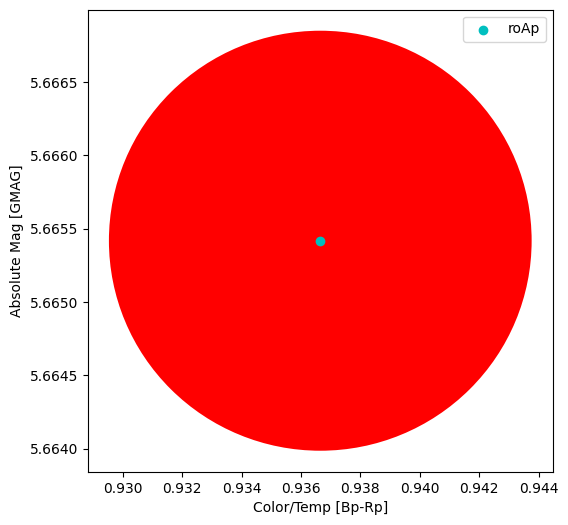

In [30]:
# Making the Ellipse Equation
ell = []
for i in range(len(xr)):
    b = ((dfr['BP-RP_mean_error']).values[i])
    a = ((dfr['G_mean_error']).values[i])
    ell.append({'b':b,'a':a})
df_ell = pd.DataFrame(ell)
a0 = (df_ell['a'][0])
b0 = (df_ell['b'][0])
xr0 = (roAp['BP-RP0'])[0]
yr0 = (roAp['GMAG0'])[0]
print(xr0,yr0,'\n',b0,a0)

fig, ax = plt.subplots(1,figsize=(6,6))

ellipse = mpatches.Ellipse(xy=(xr0,yr0),width=b0,height=a0,fc='r')
ax.add_patch(ellipse)
print(ax.patches)

plt.scatter(xr0,yr0,c='c',label='roAp')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend(loc='best')
plt.show()

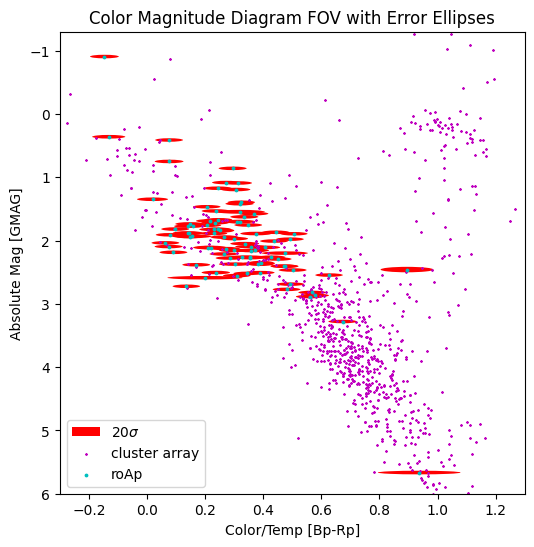

In [35]:
# Making a for loop to draw an ellipse around each roAp data point

ellipse = []
ellipse = [mpatches.Ellipse(xy=((roAp['BP-RP0'])[p],(roAp['GMAG0'])[p]),width=20*(df_ell['b'])[p],height=20*(df_ell['a'])[p])
           for p in range(len(xr))]

fig, ax = plt.subplots(1,figsize=(6,6))

for e in ellipse:
    ax.add_patch(e)
    e.set_facecolor('r')
e.set_label('20$\sigma$')

plt.scatter(x=xc,y=yc,marker='*',c='m',label='cluster array',s=1)
plt.scatter(x=xr,y=yr,c='c',label='roAp',s=3)

plt.gca().invert_yaxis()

plt.title('Color Magnitude Diagram FOV with Error Ellipses')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend(loc='best')
plt.xlim(-.3,1.3)
plt.ylim(6,-1.3)
plt.savefig('Data/CMD with Error Ellipses')
plt.show()

In [32]:
# R squareed values for mag and mag error
rse = []
dist = []
cands = []

r = [np.sqrt((df_ell['a'][k])**2+(df_ell['b'][k])**2)
      for k in range(len(xr))]
rse = pd.DataFrame(r)
rse = np.tile((rse), (1,len(xc)))

d = [(sq_c[k]-sq_r[k]) for k in range(len(xr))]
dist = pd.DataFrame(d)

b = pd.DataFrame(df_ell['b'])
b = np.tile((b), (1,len(xc)))
a = pd.DataFrame(df_ell['a'])
a = np.tile((a), (1,len(yc)))
print(b[:,2],xc_array_n[0])

# Finding the slope using the average of the R array
avg_x = sum(element[0] for element in np.array([df_ell['b']])/len(np.array([df_ell['b']])))
avg_y = sum(element[0] for element in np.array([df_ell['a']]))/len(np.array([df_ell['a']]))
print('Avg x-value:',avg_x,'| Avg y-value:',avg_y,
      '\n----------------------------------------------------')

for q in range(len(xc)):
    if ((xc_array_n[0])[q]<(b[:,1])[q]) & ((yc_array_n[0])[q]<(a[:,1])[q]):
        cand = clust.iloc[q]['id']
        cands.append({'ID':cand,'Designation':(clust['designation'])[q],'GMAG':(clust['GMAG0'])[q],'BP-RP':(clust['BP-RP0'])[q],})
cands = pd.DataFrame(cands)
print(cands.head())

[0.01423586 0.0047536  0.00478804 0.0047364  0.0047486  0.00480434
 0.00496088 0.00478265 0.00486918 0.00480471 0.00474064 0.00534753
 0.00488385 0.00480943 0.00477924 0.00506493 0.0047654  0.00529743
 0.00541478 0.00476442 0.0047933  0.00477309 0.0129222  0.00480923
 0.00476584 0.00472849 0.00474141 0.00480345 0.00908446 0.00494142
 0.0049024  0.00676649 0.0053322  0.00507641 0.00520281 0.0047648
 0.00471667 0.00471629 0.00490408 0.00473364 0.00489522 0.00482066
 0.00493338 0.00479501 0.00475601 0.00475321 0.00475856 0.00481494
 0.00477524 0.00473381 0.00476105 0.00837294 0.00478918 0.00478157
 0.00479097 0.0049368  0.00481779 0.00518261 0.00472626 0.00477021
 0.00472344 0.00480873 0.00474301 0.00569224 0.00482671 0.00793477
 0.005501   0.00504363 0.00540133 0.0052226  0.00478971 0.0048014
 0.00511173 0.00522917 0.00506598 0.00481002 0.00505778 0.00494761
 0.0047295  0.00473523 0.0047452  0.0048476  0.00488961 0.0048114
 0.00497766 0.00472803 0.00472043] [ 2.405985e+00 -2.110340e-01  

IndexError: index 87 is out of bounds for axis 0 with size 87

### DOESNT WORK, FIGURE OUT HOW TO MAKE THE A AND B VALUES SAME LENGTH AS CLUSTER DATASET

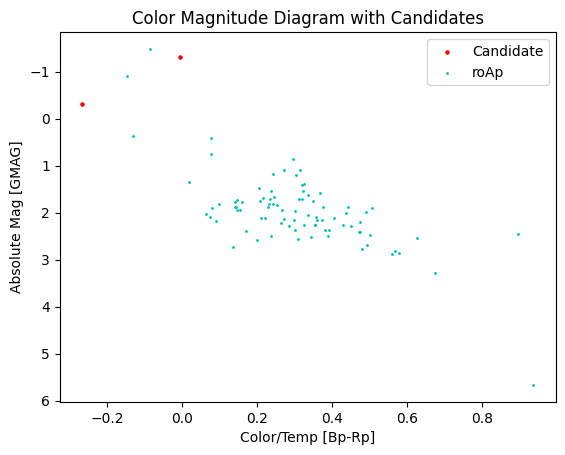

In [ ]:
ub = cands['BP-RP']
ua = cands['GMAG']

plt.scatter(ub,ua,c='r',label='Candidate',s=5)
plt.scatter(x=xr,y=yr,c='c',label='roAp',s=1)

plt.gca().invert_yaxis()

plt.title('Color Magnitude Diagram with Candidates')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend(loc='best')
plt.savefig('Data/CMD with Cands')
plt.show()

In [ ]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = mpatches.Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
